In [1]:
import pathlib
import cvxpy as cp
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import sea2025

data = sea2025.data.read("data/ne8bus")

# Take references for brevity
buses = data.buses
generators = data.generators
lines = data.lines
loads = data.loads
offers = data.offers
reference_bus = data.reference_bus
base_power = data.base_power

# Make the problem smaller for demo purposes
loads = loads.iloc[: loads.index.size // 1, :]
x_on_initial = np.repeat(0, generators.index.size)

# Incidence matrices to simplify the formulation
line_bus = sea2025.incidence.line_bus(buses=buses, lines=lines)
generator_bus = sea2025.incidence.generator_bus(buses=buses, generators=generators)
offer_bus = sea2025.incidence.offer_bus(
    buses=buses, offers=offers, generators=generators
)
generator_offer = sea2025.incidence.generator_offer(
    generators=generators, offers=offers
)
reference_bus_index = sea2025.incidence.reference_bus(buses, reference_bus)

# More references for brevity
offer_quantity = offers["quantity"].values
offer_price = offers["price"].values
p_min = generators["capacity"].values * 0.2
p_max = generators["capacity"].values
reactance_pu = lines["reactance"].values
line_capacity = lines["capacity"].values
ramp = generators["ramp_rate"].values
startup_cost = generators["startup_cost"].values
shutdown_cost = np.zeros(startup_cost.size)  # unavailable!
noload_cost = generators["noload_cost"].values

# Uncomment for minimum up/down-time constraints
# min_uptime = generators["min_uptime"].values
# min_downtime = generators["min_downtime"].values

bus_ids = buses["id"].tolist()
assert set(loads.columns).issuperset(bus_ids)
assert loads.index[0] == 0

# Continuous decision variables
p = cp.Variable((len(offers), len(loads)), name="p")
f = cp.Variable((len(lines), len(loads)), name="f")
θ = cp.Variable((len(buses), len(loads)), name="θ")

# Binary decision variables
x_on = cp.Variable((len(generators), len(loads)), name="x_on", boolean=True)
x_su = cp.Variable((len(generators), len(loads)), name="x_su", boolean=True)
x_sd = cp.Variable((len(generators), len(loads)), name="x_sd", boolean=True)

# Constraints to come
constraints: list[cp.Expression] = []
for t in loads.index:
    bus_loads = loads.loc[t, bus_ids]
    bus_injections = offer_bus.T @ p[:, t] + line_bus.T @ f[:, t]
    line_flows = cp.multiply(line_bus @ θ[:, t], base_power / reactance_pu)
    p_total_now = generator_offer @ p[:, t]
    constraints.extend(
        [
            bus_injections == bus_loads,
            f[:, t] == line_flows,
            θ[reference_bus_index, t] == 0,
            # Injection bounds
            p[:, t] >= 0,
            p[:, t] <= offer_quantity,
            p_total_now >= cp.multiply(x_on[:, t], p_min),
            p_total_now <= cp.multiply(x_on[:, t], p_max),
            # Flow bounds
            f[:, t] >= -line_capacity,
            f[:, t] <= +line_capacity,
            # Transitions are mutually exclusive
            x_su[:, t] + x_sd[:, t] <= 1,
            # Sanity check
            cp.abs(θ[:, t]) <= np.pi,
        ]
    )
    if t > 0:
        p_total_prev = generator_offer @ p[:, t - 1]
        constraints.extend(
            [
                # Ramping constraints
                p_total_now - p_total_prev <= ramp, # + cp.multiply(p_max, x_su[:, t]),
                p_total_prev - p_total_now <= ramp, # + cp.multiply(p_max, x_sd[:, t]),
                # Binary logic
                x_su[:, t] - x_sd[:, t] == x_on[:, t] - x_on[:, t - 1],
            ]
        )

    # Constraints for minimum up/down-time: Implementation #1 - very expensive
    # for g in generators.index:
    #     constraints.extend(
    #         x_on[g, t + τ] >= x_su[g, t]
    #         for τ in range(min_uptime[g])
    #         if t + τ < series.hour.size
    #     )
    #     constraints.extend(
    #         x_on[g, t + τ] <= 1 - x_sd[g, t]
    #         for τ in range(min_downtime[g])
    #         if t + τ < series.hour.size
    #     )

# # Constraints for minimum up/down-time: Implementation #2 - expensive
# for g in generators.index:
#     constraints.extend(
#         cp.sum(x_on[g, t : t + min_uptime[g]]) >= min_uptime[g] * x_su[g, t]
#         for t in range(series.hour.size - min_uptime[g])
#     )
#     constraints.extend(
#         cp.sum(x_on[g, t : t + min_downtime[g]]) <= min_downtime[g] * (1 - x_sd[g, t])
#         for t in range(series.hour.size - min_downtime[g])
#     )

In [2]:
# Solution time increasees with problem size
print(f"# Constraints: {len(constraints)}")

# Objective function
objective = cp.Minimize(
    cp.sum(
        [
            offer_price @ p[:, t]
            + noload_cost @ x_on[:, t]
            + startup_cost @ x_su[:, t]
            + shutdown_cost @ x_sd[:, t]
            for t in loads.index
        ]
    )
)

# Constraints: 1341


In [3]:
# Preprocess and solve the ptimization problem
problem = cp.Problem(objective, constraints)
problem.solve(solver=cp.HIGHS, verbose=True)
print(f"       Status: {problem.status}")
print(f" Optimal cost: ${problem.value:,.2f}")

p_generator = generator_offer @ p.value
prices = offers.groupby("generator_id")["price"]
prices_min = prices.min().values
prices_max = prices.max().values

ntop = 5
stdev = np.std(p_generator, axis=1)
indices = np.sort(np.argpartition(stdev, -ntop)[-ntop:])

pmin = np.min(p_generator[indices, :])
pmax = np.max(p_generator[indices, :])

                                     CVXPY                                     
                                     v1.6.5                                    
(CVXPY) May 27 11:36:52 AM: Your problem has 38400 variables, 77820 constraints, and 0 parameters.
(CVXPY) May 27 11:36:52 AM: It is compliant with the following grammars: DCP, DQCP
(CVXPY) May 27 11:36:52 AM: (If you need to solve this problem multiple times, but with different data, consider using parameters.)
(CVXPY) May 27 11:36:52 AM: CVXPY will first compile your problem; then, it will invoke a numerical solver to obtain a solution.
(CVXPY) May 27 11:36:52 AM: Your problem is compiled with the CPP canonicalization backend.
-------------------------------------------------------------------------------
                                  Compilation                                  
-------------------------------------------------------------------------------
(CVXPY) May 27 11:36:52 AM: Compiling problem (target solver=HIGH

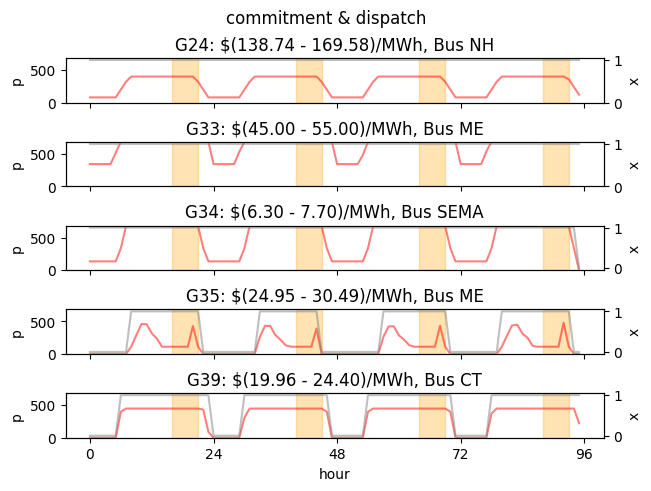

In [4]:
fig, axes = plt.subplots(nrows=ntop, sharex=True, constrained_layout=True)

handles = []
for i, ax_p in zip(indices, axes):
    ax_x = ax_p.twinx()

    (h1,) = ax_p.plot(p_generator[i, :], color="red", label="p [MW]", alpha=0.5)
    (h2,) = ax_x.plot(x_on.value[i, :], color="gray", label="x [0/1]", alpha=0.5)

    ax_p.set_title(
        (
            f"{generators.at[i, 'id']}: "
            f"$({prices_min[i]:.2f} - {prices_max[i]:.2f})/MWh, "
            f"Bus {generators.at[i, 'bus_id']}"
        )
    )
    ax_p.set_xlabel("hour")
    ax_p.set_xticks(range(0, p_generator.shape[1] + 1, 24))
    ax_p.set_ylim(pmin, pmax)
    ax_p.set_ylabel("p")
    ax_x.set_ylabel("x")
    ax_x.set_yticks([0, 1])

    # Remove x-axis labels for all but the bottom plot
    if ax_p != axes[-1]:
        ax_p.set_xlabel("")

    # Shade peak hours each day
    peak_start = 16  # [hour]
    peak_end = 21  # [hour]
    h3s = [
        ax_p.axvspan(
            offset + peak_start,
            offset + peak_end,
            color="orange",
            alpha=0.3,
            label=f"peak ({peak_start:02d}H-{peak_end:-02d}H)",
        )
        for offset in range(0, p_generator.shape[1], 24)
    ]

    # Collect legend handles (only once)
    if len(handles) == 0:
        handles.extend([h1, h2, h3s[1]])

fig.suptitle("commitment & dispatch")
axes[-1].set_xlabel("hour")
plt.show(block=False)